In [1]:
import sys
import io
import os
import traceback
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
import sqlite3
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import datetime as dt
from sklearn import linear_model
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
import json
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import openai
import pandas as pd
import sqlite3
from openai.api_resources.completion import Completion
import re
import api_call
from langchain.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_function
import importlib
import os
import sys
import openai
import requests
from inspect import getmembers, isfunction
import inspect

In [2]:
# !pip install openai
!pip3 install openai





DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/tokenizers-0.14.1-py3.11-macosx-12-arm64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/urllib3-1.26.17-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/sympy-1.12-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/google_auth-2.23.3-py3.11.egg is deprecated. p

In [6]:
# Connect to the sqlite db file and retrieve data as Pandas data frame.
cnx = sqlite3.connect('FPA_FOD_20170508.sqlite')
sql = "select * from fires"
# df = pd.read_sql_query(sql, cnx)

In [7]:
df = pd.read_sql_query(sql, cnx)
df.head()
df_interest = df[["FIRE_YEAR","DISCOVERY_DOY","DISCOVERY_TIME","CONT_DOY","CONT_TIME","STAT_CAUSE_CODE","STAT_CAUSE_DESCR","FIRE_SIZE","LATITUDE","LONGITUDE","STATE","COUNTY","FIPS_NAME","DISCOVERY_DATE"]]
df_interest.isna().sum()
print(f"Number of removed duplicate rows: {df_interest.duplicated().sum()}")
df_interest = df_interest.drop_duplicates()
df_interest["combined_date_dis"] = df_interest["FIRE_YEAR"]*1000 + df_interest["DISCOVERY_DOY"]
df_interest["combined_date_dis"] = pd.to_datetime(df_interest["combined_date_dis"], format = "%Y%j")
df_interest = df_interest.set_index("combined_date_dis")
df_interest.head()

Number of removed duplicate rows: 3525


,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DOY,CONT_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_NAME,DISCOVERY_DATE
combined_date_dis,,,,,,,,,,,,,,
2005-02-02,2005,33,1300,33.0,1730,9.0,Miscellaneous,0.10,40.036944,-121.005833,CA,63,Plumas,2453403.5
2004-05-12,2004,133,0845,133.0,1530,1.0,Lightning,0.25,38.933056,-120.404444,CA,61,Placer,2453137.5
2004-05-31,2004,152,1921,152.0,2024,5.0,Debris Burning,0.10,38.984167,-120.735556,CA,17,El Dorado,2453156.5
2004-06-28,2004,180,1600,185.0,1400,1.0,Lightning,0.10,38.559167,-119.913333,CA,3,Alpine,2453184.5
2004-06-28,2004,180,1600,185.0,1200,1.0,Lightning,0.10,38.559167,-119.933056,CA,3,Alpine,2453184.5


In [8]:
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'Shape'], dtype='object')

In [9]:


# Set up OpenAI API key
openai.api_key = 'xxxxxxxxxxxxx'

f = open("columns.txt", "r")
col_txt = f.read()
#summarise

In [10]:
def query_database(sql_query):
    """
    Executes a SQL query against the SQLite database.
    """
    return pd.read_sql_query(sql_query, cnx)

def generate_sql_query(messages):
    """
    Uses OpenAI's GPT-4 to generate a SQL query based on a natural language prompt.
    """
    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=messages
    )
    return response.choices[0].message['content'].strip()


def run_tool(json_query):
    """
    Uses OpenAI's GPT-4 to generate a SQL query based on a natural language prompt.
    """
    if(json_query["tool_name"] == "Query_Database"):
        try:
            df1 = query_database(json_query["command"])
            print(df1)
            data = df1.head().to_dict(orient='records')  # Converts the DataFrame head to a list of dictionaries
            return data
        except:
            print("Incorrect sql command. Trying again")
            return "Retry SQL Query"
    if(json_query["tool_name"] == "Generate_Final_Answer"):
        return "Finish"
        

In [11]:
import openai

def llm_generate_plan(query):
    """
    Generates a detailed plan using an LLM based on the provided query.
    
    Args:
        query (str): A natural language description of the task to be planned.
    
    Returns:
        list: A list of actionable steps derived from the LLM's response.
    """
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",  # Specify the appropriate model
#             temperature = 0.7,
            messages=[
                {"role": "user", "content": query}
            ]

        )
        plan_text = response['choices'][0]['message']['content']
        steps = plan_text.split('\n') 

        return plan_text
    except Exception as e:
        print("Error in contacting the LLM:", e)
        return []



In [12]:
import re

def extract_numbered_list_items(text):
    """
    Extracts numbered list items from the provided text.

    Args:
        text (str): The input text from which numbered list items will be extracted.
    
    Returns:
        list: A list of strings, each a numbered list item containing numbers.
    """
    # Regex to find lines starting with one or more digits followed by a period and optional whitespace
    pattern = r'\n?(\d+\.\s+.*?(?=\n\d+\.|\n\n|\Z))'
    numbered_items = re.findall(pattern, text, flags=re.DOTALL)

    return [item.strip() for item in numbered_items]


In [13]:
# Step 1: Plan generation

def planner(query, error_str = "None", code = "", plan_txt= ""):
    print(query)
    prompt= '''<s> [INST]
    You are a planning module specifically designed for data analysis tasks involving SQLite databases. You will receive natural language queries and must develop a clear, step-by-step plan for data analysis, directing the code generator on how to execute each step effectively. The plan should outline necessary SQL queries, data preprocessing steps, analytical methods, and final reporting formats, specifying all variable names and any new DataFrames or structures needed.

    You will interact with a code generator or tool user to extract insights from a SQLite database. Ensure each instruction is precise and clear to facilitate accurate code generation. Ensure each variable is also properly defined and formatted so that the code generator makes few mistakes. Make sure you use the column names existing in the dataframe based on previous planning steps.

    TASK: Draft a comprehensive, step-by-step plan to perform data analysis on the specified SQLite table named 'fires'. This table contains extensive data on wildfires. The plan should outline the necessary SQL queries, data preprocessing steps, analytical methods, and final reporting formats. Mention all variable names clearly and specify any new DataFrames or structures needed. Do not assume functions and keep changing variable names.
    Be very clear of any variable names you provide. Do not be vague with respect to planning. Use the column names provided in the prompt.
    DATABASE DETAILS:
    - Database: SQLite
    - Table Name: fires

    MEMORY:
    Context: The 'fires' table contains a comprehensive spatial database of wildfires that occurred in the United States from 1992 to 2015. This data supports national Fire Program Analysis (FPA) systems. The records, sourced from federal, state, and local fire organizations, include essential elements such as discovery date, final fire size, and point locations precise to at least the Public Land Survey System (PLSS) section (1-square mile grid). The data conforms to standards set by the National Wildfire Coordinating Group (NWCG) and includes error-checking and redundancy removal. This data publication, known as the Fire Program Analysis fire-occurrence database (FPA FOD), comprises 1.88 million geo-referenced wildfire records, representing 140 million acres burned over a 24-year period.

    Column Information:
    '''
    prompt+= col_txt
    prompt+='''
    TOOLS
    PCA_Analysis: This involves reducing the dimensionality of the dataset to identify the principal components that explain the most variance. The process will require standardizing the data, applying the PCA transformation, and interpreting the results to understand the data's underlying structure.
    Prophet_module: Use this module to perform time series forecasting. Prepare the dataset by aggregating values into a daily sum if necessary, then rename the columns to 'ds' for the timestamp and 'y' for the variable of interest. Fit the Prophet model to the data to predict future trends and identify change points.
    add_changepoints_to_plot: After fitting the Prophet model, use this function to visualize the trend and any detected change points in the time series, providing insights into the timing and magnitude of changes in the trend.
    Remove_duplicates: Inspect the dataset for duplicate entries based on all or a subset of columns and remove any found duplicates to maintain data integrity.
    LinearRegression: Instantiate and use the LinearRegression class for predictive modeling on numerical data. Ensure the data is cleaned, relevant features are selected, and any categorical variables are encoded before training the model.
    Datetime Conversion: Convert epoch timestamps into a human-readable date format (mm/dd/yyyy) and ensure that all date-time columns are in this format for consistency and analysis.
    Metric Extraction: Define which metrics are needed for analysis and extract them from the dataset, creating a new dataframe that includes these metrics explicitly for further analysis.
    Classifier - XGBClassifier: Deploy the XGBClassifier for classification tasks. Preprocess the dataset to convert all feature columns into numerical data types to avoid type conversion errors during model training.
    Label Encoder: Use this encoder to transform categorical data into a machine-readable form. Apply the encoding before model training and use the inverse transform to decode predictions back into the original categorical format.
    RandomForestClassifier (rf_model): Implement the RandomForestClassifier with a designated variable name (rf_model). Train the model on the preprocessed dataset, ensuring all input features are in a suitable format for the classifier.
    Classification_Report: Generate a classification report to evaluate the performance of classification models. The report should include metrics such as accuracy, precision, recall, F1 score, and support.
    Inverse transform: After making predictions with encoded labels, use the inverse transformation to convert the predicted labels back to their original categorical values.
    Data_Encoding: Apply data encoding methods to categorical columns using label encoders. Ensure the process includes mapping strategies for both forward transformation (encoding) and inverse transformation (decoding).
    Split Date Format: Parse date-time columns to extract temporal features like week number, month, and day. This aids in converting date-time data into individual integer components for models that require numerical inputs.
    Null Value Replacement: Identify columns with null or missing values and decide on a strategy to handle these, such as imputing a suitable data type and value or removing rows with missing data.




    Remember, your goal is to provide clear, executable instructions that a code generator can follow to generate code. Be very clear and define variables whenever needed. Use in-context example as a sample.

    In-context examples:

    User: 'Given the size, location and date, Predict the cause of a fire wildfire.'
    Assistant:
    1. Data Preparation:
    Load and Clean Data: Import the dataset and select relevant columns such as 'FIRE_YEAR', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'DISCOVERY_DATE', 'CONT_DOY', 'CONT_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'STATE', and 'FIPS_NAME'. Remove duplicate records to ensure data quality.
    2. Feature Engineering:
    Date and Time Conversion: Convert 'FIRE_YEAR' and 'DISCOVERY_DOY' to a datetime format to create a 'combined_date_dis' column. Similarly, combine 'FIRE_YEAR' and 'CONT_DOY' to create 'combined_date_con', ensuring both discovery and containment times are included.
    Calculate Duration: Compute the duration of the fire by subtracting the discovery datetime from the containment datetime. Extract additional temporal features like weekday and month from the discovery date.
    3. Exploratory Data Analysis (EDA):
    Check Data Balance: Assess the balance of the categories within 'STAT_CAUSE_DESCR' and plan for potential data resampling if significant imbalances are detected.
    Correlation Analysis: Calculate and visualize the correlation matrix for all numerical features to identify any strong correlations or redundancies. Drop highly correlated or redundant features to simplify the model.
    4. Feature Engineering Continued:
    Handle Categorical Data: Apply label encoding to categorical variables such as 'STATE' and 'FIPS_NAME' due to their high cardinality, which makes one-hot encoding impractical.
    Feature Selection: Select significant features for the model, focusing on those most relevant for predicting fire causes, such as location, size, and date-derived features.
    Instead of using STAT_CAUSE_CODE as label, implement LE for STAT_CAUSE_DESCR because STAT_CAUSE_CODE starts from 1.
    Model Preparation:
    5. Data Splitting: Divide the data into training and testing sets to ensure a robust evaluation of the model's predictive performance.
    Handle Missing Data: Decide on strategies for handling missing data, whether imputing values or dropping rows, especially for key features used in the models.
    Model Training and Evaluation:
    6. Choose Algorithm: Train several machine learning model XGBoost, which are well-suited for handling the categorical nature and complexity of the dataset.
    7. Feature Importance: Analyze the importance of different features in the model to gain insights into what factors most influence the prediction of fire causes.
    Model Insights: Provide comprehensive insights and recommendations based on the model outcomes, highlighting key predictive factors and potential areas for further research or operational integration.


    User: Have wildfires become more or less frequent over time?
    Assistant:
    1. Data Preparation
    Load the dataset into a DataFrame named df_interest by directly querying Select relevant columns related to fire occurrences and timing, such as 'FIRE_YEAR', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'CONT_DOY', 'CONT_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'FIPS_NAME', and 'DISCOVERY_DATE'. Store these in df_interest.
    Check for and summarize any missing values in df_interest using the isna().sum() method.
    Remove duplicate rows to clean the data, noting how many duplicates were removed with a print statement.
    2. Date Conversion
    Create a new column 'combined_date_dis' in df_interest that combines these columns into a full date format using pandas' to_datetime function, considering 'FIRE_YEAR' as the year and 'DISCOVERY_DOY' as the day of the year.
    3. Data Aggregation
    Set the new datetime column as the index of df_interest.
    Aggregate data to analyze fire counts on a monthly and yearly basis using groupby and count methods. Store these aggregates in monthly_trend and yearly_trend, respectively, and then plot these trends.
    4. Trend Analysis Using Prophet
    Prepare the data for Prophet by resetting the index and renaming columns to 'ds' (date) and 'y' (metric, e.g., count of fires). This is necessary for compatibility with the Prophet package.
    Define a function prophet_model that sets up and runs a Prophet model. The function should accept parameters like growth assumptions, seasonality, and the number of changepoints, and output both the model and its forecasts.
    Apply the prophet_model function to the daily aggregated fire count data.
    5. Change Point Analysis
    Use Prophet's output to visualize components and trend change points. Plot the overall forecast and highlight changepoints.
    6. Linear Regression to find change point
    Divide the dataset into portions lower and upper of the change point using trend = forecast[["ds","trend"]] and using changepoints.to_list() module.
    Analyze trends before and after the first changepoint using linear regression to determine changes in the slope of the trend lines. Convert datetime to ordinal using the required libraries.
    6. Output Results
    Calculate and print the slopes of the trend lines before and after the changepoint to discuss whether wildfires have become more or less frequent over time.

    User: What counties are the most and least fire-prone? \n
    Assistant: 
    1. Execute an SQL query to extract records from the fire incidents database. Retrieve all relevant columns for state, county, and monthly fire counts for each county. Store the results in a DataFrame named monthly_fire_counts.
    2. In the monthly_fire_counts DataFrame, merge the state and county names into a single column named 'State_County'. This facilitates easier aggregation and analysis.
    3. Using SQL, aggregate the total number of fires, the cumulative fire duration, and the total area affected by fires for each county. Store these aggregated metrics in a new DataFrame named county_fire_stats.
    4. Standardize the metrics (total fires, duration, and area) in the county_fire_stats DataFrame using z-scores to allow comparison across different scales and distributions.
    5. Apply PCA to the standardized metrics in county_fire_stats to reduce dimensionality and identify the principal components that explain the most variance in the data.
    6. Analyze the explained variance of each principal component to identify the most significant component that correlates with fire proneness.
    7. Determine the counties with the highest and lowest scores on the principal component that shows the highest variance. These scores will indicate the most and least fire-prone counties.
    8. Print the names of the counties that are identified as the most and least fire-prone based on the analysis.


    [/INST]

    User:
    '''
    prompt+= query
    if(error_str!="None"):
        prompt = f"""
                ### Task: Correct and Enhance Data Analysis Plan
                ## Context:
                - A previous attempt at generating a data analysis plan resulted in errors. The task involves correcting these errors and enhancing the plan for effective data analysis using the SQLite 'fires' table.

                ## Database Details:
                - Database: SQLite
                - Table Name: fires
                - Columns: {col_txt}

                ## Error Details:
                - Error Message in step no.: {error_str}
                - Previous Code That Caused the Error:
                ```python
                {code}
                ```

                ## Previous Plan Steps:
                {plan_txt}
                
                ### Query asked
                {query}

                ## Instructions:
                <INST>
                - Analyze the error and the previous code to understand what went wrong.
                - Revise the plan steps to correct the errors identified. Ensure the new plan is robust, error-free, and tailored to the needs of the 'fires' data analysis.
                - Clearly number and articulate each step of the new plan, starting from data preparation to final reporting. Include specific SQL queries, data preprocessing steps, analytical methods, and any necessary data formatting or transformation.
                - Maintain consistent use of variable names and clear references to database columns as specified in the project guidelines.
                - Ensure the plan is executable, with clear instructions for each stage of the data analysis.
                - Make sure the error does not occur again. 
                <\INST>
                ### Revised Plan Steps Required:
                - Please generate a revised set of plan steps after updating the previous plan steps, starting from step 1, correcting previous errors, and enhancing the overall data analysis approach.
                
                """
        plan_txt = llm_generate_plan(prompt)
#             print(plan_txt)
        return extract_numbered_list_items(plan_txt), plan_txt         
    plan_txt = llm_generate_plan(prompt)
    return extract_numbered_list_items(plan_txt), plan_txt



#     - Print Final Answer: This is not a function. Treat this a plan termination. Just print the results. Use if answer to User's question can be given with MEMORY and data we have. Use this after thorough data analysis
#     - Query_Database: Write only one SQL Query to query the Database. This can only execute one query at a time
#     - PCA_Analysis: Find variance of the principal components
#     - Prophet_module: Implement prophet module to find the trends and trend change points. (from prophet import Prophet)  Convert the inputs into daily sum and change the column names to apply fpprophet.  Convert the inputs into daily sum and change the column names to apply fpprophet. Extract yearly trends.
#     - from prophet.plot import add_changepoints_to_plot #to find the trends in an automated fashion
#     - Remove_duplicates: Remove duplicate rows
#     - LinearRegression - LinearRegression()
#     - convert datetime to required format - from 223453464 to mmddyyyy
#     - extract the necessary metrics and store in dataframe
#     - Classifier - XGBClassifier (before mentioning the classifier, convert all the columns into the correct datatype to avoid errors like- Error during execution: could not convert string to float: '01/01/1970' )
#     - Label Encoder - encode when needed and decode when predicting using inverse transform or decoder
#     - RandomForestClassifier - use variable name - rf_model
#     - Classification_Report: Generate reports on classifier performance.
#     - Inverse transform
#     - Data_Encoding: Use Label Encoders for categorical data and handle inverse transformations.
#     - Split date format into week, month, day - for integer processing
#     - replace null type attributes with a suitable data type and value


In [14]:
def regenerate_code_with_reflection(error_message, previous_code, previous_plan_steps, column_info):
    """
    Regenerates the plan steps for data analysis after correcting the errors in the previous attempts.

    Args:
        error_message (str): Description of the error encountered in the previous execution.
        previous_code (str): The code that led to the error.
        previous_plan_steps (str): The initial plan steps before the error was encountered.
        column_info (str): Detailed information about the columns in the 'fires' database table.

    Returns:
        str: A revised set of plan steps addressing the previous errors and correctly setting up the data analysis pipeline.
    """
    prompt = f"""
    ### Task: Correct and Enhance Data Analysis Plan
    ## Context:
    - A previous attempt at generating a data analysis plan resulted in errors. The task involves correcting these errors and enhancing the plan for effective data analysis using the SQLite 'fires' table.
    
    ## Database Details:
    - Database: SQLite
    - Table Name: fires
    - Columns: {column_info}

    ## Error Details:
    - Error Message: {error_message}
    - Previous Code That Caused the Error:
    ```python
    {previous_code}
    ```

    ## Previous Plan Steps:
    {previous_plan_steps}

    ## Instructions:
    - Analyze the error and the previous code to understand what went wrong.
    - Revise the plan steps to correct the errors identified. Ensure the new plan is robust, error-free, and tailored to the needs of the 'fires' data analysis.
    - Clearly number and articulate each step of the new plan, starting from data preparation to final reporting. Include specific SQL queries, data preprocessing steps, analytical methods, and any necessary data formatting or transformation.
    - Maintain consistent use of variable names and clear references to database columns as specified in the project guidelines.
    - Ensure the plan is executable, with clear instructions for each stage of the data analysis.

    ### Revised Plan Steps Required:
    - Please generate a revised set of plan steps, starting from step 1, correcting previous errors, and enhancing the overall data analysis approach.

    
    """

    # Simulate call to an AI service to generate the corrected plan based on the prompt
    revised_plan_steps = ai_generate_code(prompt)
    return revised_plan_steps

# # Example usage of the function:
# column_details = "FIRE_YEAR, DISCOVERY_DOY, DISCOVERY_TIME, CONT_DOY, etc."
# error = "NameError: name 'dataframe' is not defined"
# code = "print(dataframe.head())"
# plan_steps = """
# 1. Load data into 'df_fires'.
# 2. Summarize missing values.
# 3. Convert date columns.
# 4. Aggregate data for analysis.
# """
# corrected_plan = regenerate_code_with_reflection(error, code, plan_steps, column_details)
# print(corrected_plan)


In [15]:
import openai
import yaml
local_environment = {'df': df_interest}

def load_plugin_schema(plugin_name):
    """
    Loads the plugin schema from a YAML file.
    
    Args:
        plugin_name (str): The name of the plugin.
        
    Returns:
        dict: The plugin schema including name, arguments, and metadata.
    """
    with open(f"{plugin_name}.yaml", 'r') as file:
        plugin_schema = yaml.safe_load(file)
    return plugin_schema

def extract_python_code(text):
    """
    Extract Python code blocks from the provided text string.

    Args:
        text (str): A string containing mixed content including Python code blocks.

    Returns:
        list of str: A list containing the extracted Python code blocks.
    """
    # Split the text by triple backticks to find potential code blocks
    parts = text.split('```python')
    code_blocks = []

    # Iterate over parts that come after `python` indicated by backticks
    for part in parts[1:]:  # skip the first split as it won't contain code
        # Find the first occurrence of triple backticks which marks the end of the code block
        end_idx = part.find('```')
        if end_idx != -1:
            # Extract the code block up to the ending backticks
            code_blocks.append(part[:end_idx].strip())

    return code_blocks

In [16]:
def regenerate_code_with_reflection(original_code, error_message,code_prompt):
    """
    Use LLM to regenerate the code based on the error encountered.
    """
    prompt = f"Correct this Python code which caused an error:\nError: {error_message}\nCode: {original_code}\n# Use {code_prompt} for reference to correct it"
    
    prompt = (
        f"### Error Correction Task\n"
        f"## Context:\n"
        f"- An error occurred during the execution of this Python code, which is part of a larger project involving data analysis.\n"
        f"- Below is the erroneous code along with the error message and the code context from the broader project.\n"
        f"- Your task is to correct the code to resolve the error and ensure it aligns with the project's objectives and coding standards.\n\n"
        f"## Error Details:\n"
        f"- Error Message: {error_message}\n\n"
        f"## Original Code Causing the Error:\n"
        f"```python\n"
        f"{original_code}\n"
        f"```\n\n"
        f"## Project Code Context (Reference):\n"
        f"```python\n"
        f"{code_prompt}\n"
        f"```\n\n"
        f"## Instructions:\n"
        f"- Correct the original code to eliminate the error.\n"
        f"- Ensure the corrected code integrates seamlessly with the provided project code context.\n"
        f"- Maintain consistency with the coding practices and standards used in the project.\n"
        f"- Provide explanations for the changes made to help understand the correction process.\n"
        f"- Make sure the type matches correctly for the classifiers"
        f"- Import the correct/required libraries"
        f"- Where possible, convert data types explicitly to compatible types before operation. For example, convert timedelta to numeric types (such as total seconds) if the operation requires numeric computation."
        f"- For variables like date, create new columns to support multiple datatypes like datetimelike, int, and so on"
        f"- For variable type errors, try to clean the data before predictive modelling"
        f"- Check the existence of the columns before dropping them"
        f"- Specify datetime formats clearly - for example format='%m%d%Y for better processing"
        f"- For column type errors, recheck previous code to properly correct new code"
        f"<INST> Generate only python code <\INST>"
    )

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content":prompt},
        ]
    )
    corrected_code = response['choices'][0]['message']['content']
#     print("Corrected_code")
#     print(corrected_code)
    return corrected_code
def run_code_with_custom_globals(generated_code):
    """
    Executes the provided Python code using custom globals and captures the output.
    
    Args:
        generated_code (str): Python code to be executed.
        local_environment (dict): Custom global variables for the execution environment.
    
    Returns:
        str: Output from executing the code.
    """
    old_stdout = sys.stdout
    redirected_output = sys.stdout = io.StringIO()   


    try:
        exec(generated_code, local_environment)
    except Exception as e:
        print(f"Error during execution: {e}", file=sys.stdout)
    finally:
        sys.stdout = old_stdout

    output = redirected_output.getvalue()
    redirected_output.close()
    return output

In [17]:

def generate_run_code(plan_steps, plugin_schemas):
#     print("entered")
#     print(plan_steps)
    """
    Generates Python code based on the given plan using specified plugins. Follow the plan as specified. Do not use additional models. Do as specified. Do not assume anything. If you need any variable, process it and used. Define variables concretely.
    
    Args:
        plan_steps (list): Steps defined by the planner.
        plugin_schemas (dict): Dictionary of loaded plugin schemas.
    
    Returns:
        str: Generated Python code.
    """
    code = ""
    code_prompt =  '''<s> [INST]
    Generate Python code for the given request. Import the necessary libraries first. Ensure that the generated code is ready for direct execution without requiring predefined variables outside of this context. Do not use the fbprophet package; use the Prophet package instead for trend analysis. Use from prophet import Prophet
    DATABASE DETAILS:
    - Database: SQLite
    - Table Name: fires stored in df
    - cnx = sqlite3.connect('FPA_FOD_20170508.sqlite')
    - USE cnx to query the database using sqlite commands


    MEMORY:
    Context: The 'fires' table contains a comprehensive spatial database of wildfires that occurred in the United States from 1992 to 2015. This data supports national Fire Program Analysis (FPA) systems. The records, sourced from federal, state, and local fire organizations, include essential elements such as discovery date, final fire size, and point locations precise to at least the Public Land Survey System (PLSS) section (1-square mile grid). The data conforms to standards set by the National Wildfire Coordinating Group (NWCG) and includes error-checking and redundancy removal. This data publication, known as the Fire Program Analysis fire-occurrence database (FPA FOD), comprises 1.88 million geo-referenced wildfire records, representing 140 million acres burned over a 24-year period.

    Column Information:

    '''
    code_prompt+= col_txt
    code_prompt+='''
    TOOLS
    - Print Final Answer: This is not a function. Treat this a plan termination. Just print the results. Use if answer to User's question can be given with MEMORY and data we have. Use this after thorough data analysis
    - PCA_Analysis: Find variance of the principal components
    - Prophet_module: Implement prophet module to find the trends and trend change points. (from prophet import Prophet)  Convert the inputs into daily sum and change the column names to apply fpprophet.  Convert the inputs into daily sum and change the column names to apply fpprophet. Extract yearly trends. Use plot_components if needed.
    - Remove_duplicates: Remove duplicate rows
    - Convert Julian date format into Gregorian date format.
        df_interest["combined_date_dis"] = df_interest["FIRE_YEAR"]*1000 + df_interest["DISCOVERY_DOY"]
        df_interest["combined_date_dis"] = pd.to_datetime(df_interest["combined_date_dis"], format = "%Y%j")
        df_interest = df_interest.set_index("combined_date_dis")
        df_interest.head()
    - extract the necessary metrics and store in dataframe
    - Classifier - XGBClassifier (before mentioning the classifier, convert all the columns into the correct datatype to avoid errors like- Error during execution: could not convert string to float: '01/01/1970' )
    - Label Encoder - encode when needed and decode when predicting using inverse transform or decoder
    - RandomForestClassifier - use variable name - rf_model
    - Classification_Report: Generate reports on classifier performance.
    - Inverse transform
    - Data_Encoding: Use Label Encoders for categorical data and handle inverse transformations.
    - Split date format into week, month, day - for integer processing
    - Remove None by dropna
    - Pandas - import pandas as pd
    - Analysis of trend change points 
        trend = forecast[["ds","trend"]]
        lower_portion = trend[(trend["ds"]<m.changepoints.to_list()[0])]
        upper_portion = trend[(trend["ds"]>m.changepoints.to_list()[0])]

        # Calculate slopes with using linear Regression.
        reg_lower = linear_model.LinearRegression()
        reg_upper = linear_model.LinearRegression()

        reg_lower.fit(pd.to_datetime(lower_portion['ds']).map(dt.datetime.toordinal).values.reshape(-1, 1), lower_portion['trend'].values)
        reg_upper.fit(pd.to_datetime(upper_portion['ds']).map(dt.datetime.toordinal).values.reshape(-1, 1), upper_portion['trend'].values)

        print(f"Slope before changepoint({m.changepoints.to_list()[0]}): {reg_lower.coef_}")
        print(f"Slope before changepoint({m.changepoints.to_list()[0]}): {reg_upper.coef_}")
        
    CODE GENERATION SPECIFICATIONS:
    1. Define all intermediate data structures or variables explicitly.
    2. Ensure all necessary libraries are imported at the beginning of the script.
    3. Write clear comments within the code to describe each operation.
    4. For each tool mentioned, include a code snippet that initializes the tool, performs the operation, and stores or prints the result.
    5. Make sure to handle all data preprocessing within the script, including the conversion of date formats, encoding of categorical variables, and preparation of the dataset for machine learning models.
    6. Avoid these errors - DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:DISCOVERY_DATE: object
    7. Use Previous steps/CODE to define the variable names properly and reuse them if needed
    8. Avoid variable name errors by carefully using <CODE> to define the variables
    9. Extract relevant features which will be useful for prediction and they all follow the necessary range of values consistently
    10. replace null type attributes with a suitable data type and value
    11. Check within the prompt for the necessary column names. Do not assume column names

    [/INST]
    Previous steps <CODE>:
    '''
    counter = 0
    f = open("execution_results.txt", "w")
    f_error = open("error_results.txt","w")
    f_code = open("code_txt.txt","w")
    error_counter =0
    execution_result = ""
    for step in plan_steps:
        counter+=1
        print(counter)
        if 'plugin' in step:
            plugin_name = step.split(':')[1].strip()
            if plugin_name in plugin_schemas:
                schema = plugin_schemas[plugin_name]
                code += f"# Using plugin: {plugin_name}\n"
                code += f"{schema['function_name']}({', '.join(f'{arg}={value}' for arg, value in schema['arguments'].items())})\n"
        else:
            # Generate general Python code based on LLM suggestions
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content":code_prompt},
                    {"role": "user", "content": step}
                ]
            )
            generated_code = response['choices'][0]['message']['content']
            code += f"{generated_code}\n"
            code_formatted = f"{generated_code}\n"
            tmp = extract_python_code(code_formatted)
            try:
                f_code.write(str(tmp[0])+"\n")    
            except:
                return "Error: no code generated", code, execution_result
            try:
                execution_result = run_code_with_custom_globals(tmp[0])
            except:
                print("error in tmp")
                print(tmp)
                return "Error: no code generated", code, execution_result
                break
            if('Error' in execution_result):
                print("Error detected")
                print(execution_result)
                error_str = "Error during step " + str(counter) + "\n Error is" + execution_result 
                return error_str, code, execution_result
            code_prompt+=step
            code_prompt+=code_formatted
            f.write(str(execution_result) + "\n")
    f.close()
    f_error.close()
    f_code.close()
    return "Done", code, execution_result


# plugin_schemas = {}
# error, generated_code = generate_run_code(plan_steps, plugin_schemas)
# # tmp = extract_python_code(generated_code)
# # print(generated_code)
# print(error)

In [18]:

query = 'What counties are the most and least fire-prone?'
# query = 'Have wildfires become more or less frequent over time?'
# query = 'Given the size, location and date, Predict the cause of a fire wildfire.'
# query = 'What is this dataset about?'
# query = 'What questions can I ask?'
# query = 'What year had the highest number of wildfires?'
# query = 'Estimate the total property damage caused by wildfires in 2015.'
# query = 'What factors are most predictive of fire containment times?' #not working
# query = 'Based on historical data, predict the likelihood of a major wildfire in Texas in the next year.'
# query = 'If FIRE_SIZE is 0.1, LATITUDE is 40.036944, LONGITUDE is -121.005833, DISCOVERY_DATE is 2453403.5, predict the cause of the fire '
# plan_steps,plan_txt = planner(query)
# print(plan_steps)
# plugin_schemas = {}
# error_str, generated_code = generate_run_code(plan_steps, plugin_schemas)
# FIRE_SIZE	LATITUDE	LONGITUDE	STATE	COUNTY	FIPS_NAME	DISCOVERY_DATE

#     0.10	40.036944	-121.005833	CA	63	Plumas	2453403.5


In [19]:
def perform_data_analysis(query):
    plan_steps,plan_txt = planner(query)
    print(plan_steps)
    plugin_schemas = {}
    error_str, generated_code, output = generate_run_code(plan_steps, plugin_schemas)
    counter = 0
    while("Error" in error_str):
        counter+=1
        plan_steps, plan_txt = planner(query, error_str, generated_code, plan_txt)
        print(plan_steps)
        error_str, generated_code, output = generate_run_code(plan_steps, plugin_schemas)
        if(counter==4):
            return error_str
    return "Done"


What counties are the most and least fire-prone?
["1. **Data Preparation:**\n    - Load and Clean Data: Import the 'fires' table containing columns 'STATE', 'COUNTY', 'FIRE_SIZE', 'FIRE_NAME', 'DISCOVERY_DATE', and other relevant columns. Remove any duplicate records to ensure data quality.", "2. **Feature Engineering:**\n    - Convert Date: Create a new column 'DISCOVERY_DATE' in datetime format from the 'DISCOVERY_DATE' column for better analysis of time-related trends.\n    - Calculate Fire Frequency: Group the data by 'STATE' and 'COUNTY' and count the number of fire incidents to determine the fire frequency for each county.", '3. **Exploratory Data Analysis (EDA):**\n    - Check Data Distribution: Analyze the distribution of fire incidents across different counties to identify the most and least fire-prone areas.\n    - Visualize Data: Create visualizations like bar charts or heat maps to represent the frequency of fire incidents in each county.', '4. **Data Aggregation:**\n    - 

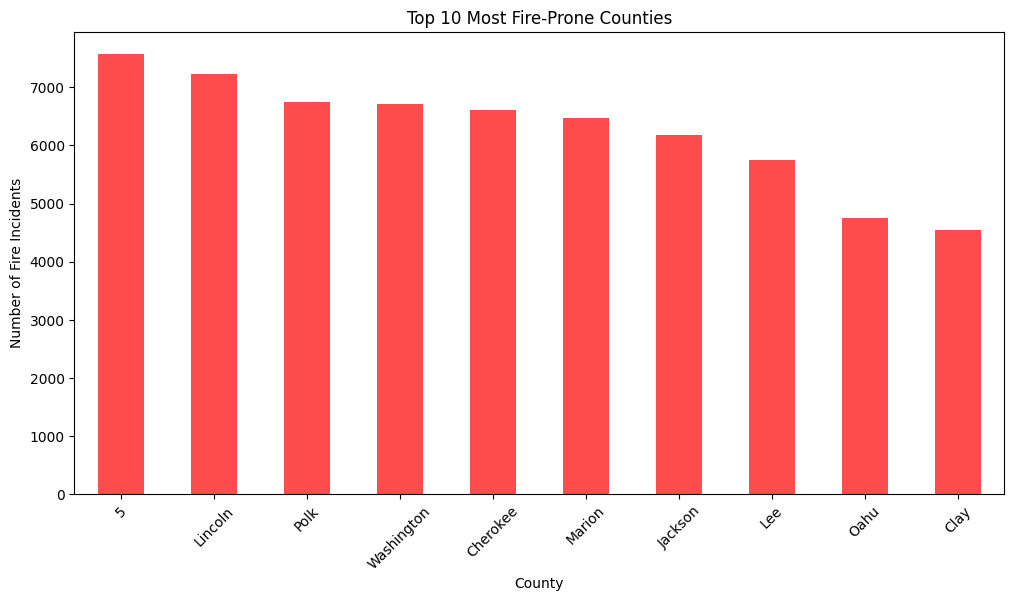

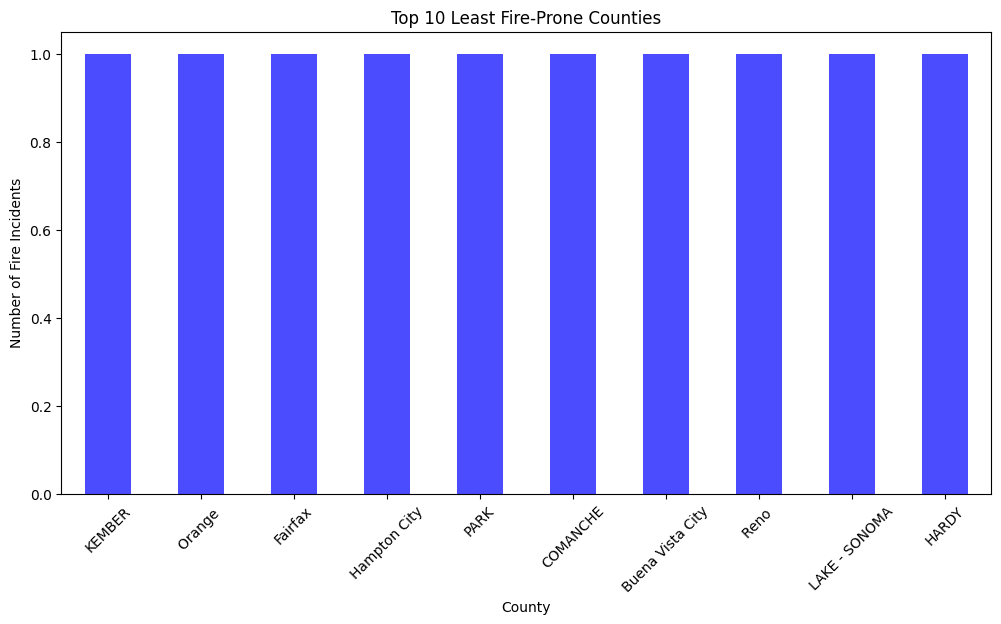

4
5


In [20]:

err = perform_data_analysis(query)
while("Error" in err):
    err = perform_data_analysis(query)

In [49]:


p = api_call.rapidapi_functions
openai_function = api_call.rapidapi_functions().get_openai_functions()
tools_directory = 'tools'
# print(openai_function)

def get_hotel_prices(location):
    return 600

def get_current_weather(location, unit="fahrenheit"):
    """Get the current weather
      in a given location"""
    if "tokyo" in location.lower():
        return json.dumps({"location": "Tokyo", "temperature": "10", "unit": unit})
    # elif "san francisco" in location.lower():
    #     return json.dumps({"location": "San Francisco", "temperature": "72", "unit": unit})
    # elif "paris" in location.lower():
    #     return json.dumps({"location": "Paris", "temperature": "22", "unit": unit})
    elif "atlanta" in location.lower():
        return json.dumps({"location": "Paris", "temperature": "19", "unit": unit})
    else:
        return json.dumps({"location": location, "temperature": "24"})

def multiply(a: int, b: int) -> int:
    """
    Multiply two numbers a and b both integers
    """
    return a*b
def add(a: int,b: int) -> int:
    """
    "add num1 and num2, both integers"
    
    """
    return a+b
    url = f"https://adder3.p.rapidapi.com/add/"
    querystring = {'num2': a, 'num1': b, }
    
    headers = {
            "X-RapidAPI-Key": "vb3ES6u4KJdPrGDBcQUiszCxpl5tjZAyagIMqX9o1WwTY7OFLV",
            "X-RapidAPI-Host": "adder3.p.rapidapi.com"
        }


    response = requests.get(url, headers=headers, params=querystring)
    try:
        observation = response.json()
    except:
        observation = response.text
    return observation
def perform_data_analysis(query):
    """
    Perform data analysis on fires table. Send the relevant part of the query to this function and get the answer.
    
    """    
    plan_steps,plan_txt = planner(query)
    print(plan_steps)
    plugin_schemas = {}
    error_str, generated_code, output = generate_run_code(plan_steps, plugin_schemas)
    counter = 0
    while("Error" in error_str):
        counter+=1
        plan_steps, plan_txt = planner(query, error_str, generated_code, plan_txt)
        print(plan_steps)
        error_str, generated_code, output = generate_run_code(plan_steps, plugin_schemas)
        if(counter==4):
            return error_str
    return output
def finish():
    """
    If you believe that you have obtained a result that can answer the task, please call this function to provide the final answer. Alternatively, if you recognize that you are unable to proceed with the task in the current state, call this function to restart. Remember: you must ALWAYS call this function at the end of your attempt, and the only part that will be shown to the user is the final answer, so it should contain sufficient information.
    """
    return "Give up and restart or return final answer"
def get_function_details(func):
    """
    This function takes a function object and returns a dictionary with details of the function.
    """
    # Here you would extract the function signature and documentation to create a similar structure
    sig = inspect.signature(func)
    params = sig.parameters
    
    function_details = {
        "type": "function",
        "function": {
            "name": func.__name__,
            "description": func.__doc__,
            "parameters": {
                "type": "object",
                "properties": {},
                "required": []
            },
        }
    }
    
    for param in params.values():
        function_details["function"]["parameters"]["properties"][param.name] = {
            "type": "string",
            "description": param.name  # Replace with actual descriptions if available
        }
        if param.default is param.empty:
            function_details["function"]["parameters"]["required"].append(param.name)
    
    return function_details

def import_tools_from_dir():
    tools = []
    available_functions = {}
    for tool_folder in os.listdir(tools_directory):
        tool_path = tools_directory+ "/"+tool_folder
        for filename in os.listdir(tool_path):
            if filename.endswith('.py'):  # Assuming tools are Python files
                tool_name = tool_folder  # Remove the '.py' from the name
                module_path = os.path.join(tool_path, filename)
                spec = importlib.util.spec_from_file_location(tool_name, module_path)
                module = importlib.util.module_from_spec(spec)
                sys.modules[tool_name] = module
                spec.loader.exec_module(module)
                    
                # Iterate over all items of the module and get functions
                for item_name in dir(module):
                    item = getattr(module, item_name)
                    if inspect.isfunction(item):
                        # Convert the function to OpenAI function format
                        tool_details = get_function_details(item)
                        # tools.append(convert_to_openai_function(item))
                        tools.append(tool_details)
                        available_functions[item.__name__] = item

    # print(available_functions)
    return tools,available_functions

def match_and_rank_tools(query, tools, top = 10):
    prompt = "Given the user query, rank the following tools by relevance:\n"
    prompt += f"User Query: {query}\n\n"
    prompt += "Tools:\n"
    for idx, tool in enumerate(tools):
        tool_description = tool['function']['description']
        prompt += f"{idx + 1}: {tool_description}\n"
    
    prompt += f"\nList the top {top} most relevant tool numbers from the list above, in order. Print only the numbers separated by comma so that I can run [int(num) for num in tool_numbers.split(', ') if num.isdigit()]"
    print(prompt)
    messages = [{"role": "user", "content": prompt}]


    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo-0125",
            messages=messages,
            tools=tools,
            tool_choice = "auto"
        )
        tool_numbers = response.choices[0].message.content
        print(response.choices[0].message.content)
        ranked_tool_numbers = [int(num) for num in tool_numbers.split(', ') if num.isdigit()]
        ranked_tools = [tools[num - 1] for num in ranked_tool_numbers if num <= len(tools)]
    except Exception as e:
        print(f"Error occurred: {e}")
        ranked_tools = []

    return ranked_tools[:top]


def run_conversation(msg):
    # messages = [{"role": "user", "content": "Add numbers 2 and 5 and then send the result as power to find current"}]
    messages = msg
    tools_from_dir,available_functions_from_dir = import_tools_from_dir()
    tools = [
        {
            "type": "function",
            "function": {
                "name": "get_current_weather",
                "description": "Get the current weather in a given location",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "location": {
                            "type": "string",
                            "description": "The city and state, e.g. San Francisco, CA",
                        },
                        "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                    },
                    "required": ["location"],
                },
            }
        },
        {
            "type": "function",
            "function": {
              "name": "Finish",
              "description": "If you believe that you have obtained a result that can answer the task, please call this function to provide the final answer. Alternatively, if you recognize that you are unable to proceed with the task in the current state, call this function to restart. Remember: you must ALWAYS call this function at the end of your attempt, and the only part that will be shown to the user is the final answer, so it should contain sufficient information.",
              "parameters": {
                  "type": "object",
                  "properties": {
                      "return_type": {
                          "type": "string",
                          "enum": ["give_answer","give_up_and_restart"],
                      },
                      "final_answer": {
                          "type": "string",
                          "description": "The final answer you want to give the user. You should have this field if \"return_type\"==\"give_answer\"",
                      }
                  },
                  "required": ["return_type"],
              }
            }
        },
        {
            'type': 'function',
            'function': 
            {
                'name': 'perform_data_analysis',
                'description': '\n       Perform data analysis on fires table. Send the relevant part of the query to this function and get the answer. \n    \n    ',
                'parameters': 
                {
                    'type': 'object',
                    'properties': {'query': {'type': 'string', 'description': 'complete question relating to data analysis of fire'}},
                    'required': ['query']
                }
            }
        }
    ]

    tools = tools + openai_function +tools_from_dir
#     tools= match_and_rank_tools(msg, tools,10)
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0125",
        messages=messages,
        tools=tools,
        tool_choice="auto",  # auto is default, but we'll be explicit
    )
    print(response)
    response_message = response.choices[0].message
    tool_calls = response_message.tool_calls
    print(tool_calls)
    if tool_calls:
        available_functions = {
            "perform_data_analysis": perform_data_analysis,
            "get_current_weather": get_current_weather,
            "get_current": p.get_current,
            "add": add,
            "multiply": multiply,
            "get_bloomberg_stock_information": p.get_bloomberg_stock_information,
            "get_hotel_prices": get_hotel_prices,
            "Finish": finish,
            "get_filters": p.get_filters,
            "search_flights": p.search_flights,
            "search_flights_multicity": p.search_flights_multicity,
            "search_airport": p.search_airport,
            "get_hotel_prices": p.get_hotel_prices 
        }
        available_functions.update(available_functions_from_dir)
        # messages.append(response_message)  # extend conversation with assistant's reply
        # Step 4: send the info for each function call and function response to the model
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            print(function_name)
            function_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            # print(function_args)
            # print(function_to_call)
            func_signature = inspect.signature(function_to_call)
            func_params = func_signature.parameters
            call_args = {}

            for param in func_params.keys():
                if param in function_args:
                    # Convert parameter to appropriate type if necessary, assuming all are int for simplicity
                    call_args[param] = function_args[param]

            # Call function with dynamically prepared arguments
            
#             if(function_name == "perform_data_analysis"):
#                 function_response = function_to_call(query)
#             else:

            function_response = function_to_call(**call_args)
            # function_response = function_to_call(
            #     a=function_args.get('a'),
            #     b=int(function_args.get('b') or 0),
            # )
            messages.append({
                      "role": "assistant",
                      "content": str(response),
             })
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "function",
                    "name": function_name,
                    "content": str(function_response),
                }
            )  
        # print("First message")
        # print(messages)
        return messages
    else:
        print("No tool found")
        messages.append({
                "role": "assistant",
                "content": "No tool found",
        })
        return messages
def execute_chain(query="Say Hi", N=1):
    messages = [{"role": "user", "content": query}]
    prompt = '''You are an agent capable of utilising multiple tools for answering the query. Answer the given query by dividing it properly between tools. Just partition the question. Do not modify it.
    In context example:
    Which country is the least fire-prone, and what is the weather of that country’s largest city for today? is divided into
    Which country is the least fire-prone for one tool
    and the output of it to what is the weather of that country’s largest city for today?
    Do not modify the query
    '''
    messages = [
    {"role": "system", "content": "You are an agent capable of utilising multiple tools for answering the query. Answer the given query by dividing it properly between tools. Just partition the question. Do not modify it."},
    {"role": "user", "content": "Which country is the least fire-prone, and what is the weather of that country’s largest city for today?"}
    ]
    for _ in range(N):
        messages = run_conversation(messages)
        # print(messages)
#         insights = reflect_on_conversation(messages)
#         messages.append(insights)
#         print(insights)
    return messages


{
  "choices": [
    {
      "finish_reason": "tool_calls",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": null,
        "role": "assistant",
        "tool_calls": [
          {
            "function": {
              "arguments": "{\"query\":\"Which country is the least fire-prone?\"}",
              "name": "perform_data_analysis"
            },
            "id": "call_IJRaacr8Ctf9K9TCEip6nFSr",
            "type": "function"
          }
        ]
      }
    }
  ],
  "created": 1713516003,
  "id": "chatcmpl-9Fe4pFMiCM91pbxtsTakYRgt1pJbK",
  "model": "gpt-3.5-turbo-0125",
  "object": "chat.completion",
  "system_fingerprint": "fp_d9767fc5b9",
  "usage": {
    "completion_tokens": 23,
    "prompt_tokens": 1289,
    "total_tokens": 1312
  }
}
[<OpenAIObject id=call_IJRaacr8Ctf9K9TCEip6nFSr at 0x349c93a70> JSON: {
  "function": {
    "arguments": "{\"query\":\"Which country is the least fire-prone?\"}",
    "name": "perform_data_analysis"
  },
  "id": "c

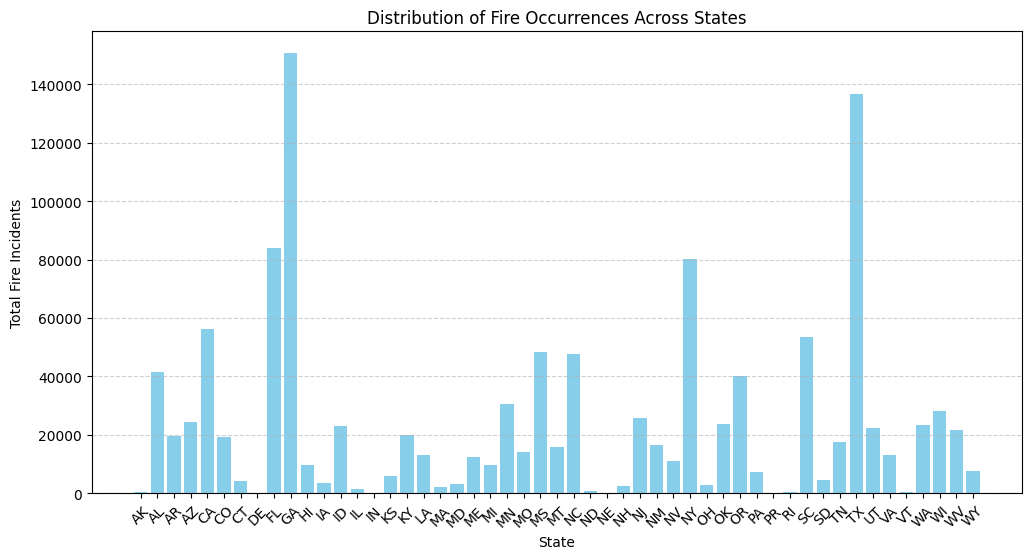

6


NameError: name 'reflect_on_conversation' is not defined

In [50]:
prompt = "You are agent capable of utilising multiple tools for answering the query. Answer the given query by dividing it properly between tools. Just partition the question. Do not modify it."
query = " Which country is the least fire-prone, and what is the weather of that country’s largest city for today?"

execute_chain(prompt+"\n"+query)

In [ ]:
!pip uninstall openai
y


In [ ]:
(1) Which state has the largest number of wildlife, and what is the state’s GDP per
capita in 2023?
(2) Which country is the least fire-prone, and what is the weather of that country’s
largest city for today?
(3) Add two complex questions that requires connecting wildfire and real-world.